In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [2]:
# Get data from Yahoo finance
df = yf.download('GLD', start='2020-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500


In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 930 entries, 2020-01-02 to 2023-09-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       930 non-null    float64
 1   High       930 non-null    float64
 2   Low        930 non-null    float64
 3   Close      930 non-null    float64
 4   Adj Close  930 non-null    float64
 5   Volume     930 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 50.9 KB


In [4]:
# Log Close
df['Log_Close'] = np.log(df['Close'])

In [5]:
# Compute the first difference of Log_Close(Log Returns)
df['Diff_Log_Close'] = df['Log_Close'].diff()

In [6]:
# Split data into train and test
Ntest = 10
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [7]:
# Standardize the Time Series values
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Diff_Log_Close']])
test_scaled = scaler.fit_transform(test[['Diff_Log_Close']])

In [8]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
# Put the Scaled Log Return back to dataframe use the column name 'Scaled_Log_Ret'
# We use flatten function because Scikit-Learn returns 2D arrays
df.loc[train_idx, 'Scaled_Log_Ret'] = train_scaled.flatten()
df.loc[test_idx, 'Scaled_Log_Ret'] = test_scaled.flatten()

In [10]:
# Make Supervised Dataset
series = df['Scaled_Log_Ret'].dropna().to_numpy()
T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t: t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

print('X Shape: ', X.shape, 'Y Shape: ', Y.shape)

X Shape:  (919, 10, 1) Y Shape:  (919,)


In [11]:
# Split our supervised dataset into train and test
Xtrain, Xtest = X[:-Ntest], X[-Ntest:]
Ytrain, Ytest = Y[:-Ntest], Y[-Ntest:]

In [12]:
# Create our LSTM Model
model = Sequential()
model.add(Input(shape=(T,1)))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 20)            1760      
                                                                 
 dropout (Dropout)           (None, 10, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 20)            3280      
                                                                 
 dropout_1 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [14]:
# Call Compile Function
model.compile(loss='mse', optimizer='adam', metrics='mae')

In [15]:
# Call Fit Function
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
29/29 [==============================] - 16s 94ms/step - loss: 1.0079 - mae: 0.7325 - val_loss: 0.9806 - val_mae: 0.7700
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 1.0062 - mae: 0.7324 - val_loss: 0.9853 - val_mae: 0.7723
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 1.0053 - mae: 0.7316 - val_loss: 0.9930 - val_mae: 0.7696
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0046 - mae: 0.7306 - val_loss: 0.9964 - val_mae: 0.7714
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 1.0037 - mae: 0.7316 - val_loss: 0.9911 - val_mae: 0.7739
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 1.0029 - mae: 0.7323 - val_loss: 0.9939 - val_mae: 0.7705
Epoch 7/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0009 - mae: 0.7314 - val_loss: 0.9966 - val_mae: 0.7714
Epoch 8/100
29/29 [==============================] - 0s 16ms/step - loss: 0

In [16]:
# History's Keys
r.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

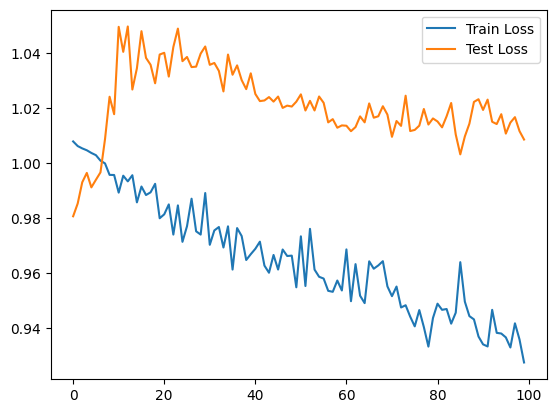

In [17]:
# Plot
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.legend();

In [18]:
# First T values are not predictable
train_idx[:T+1] = False

In [19]:
# Make Prediction
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
Ptrain.shape

1/1 [==============================] - 0s 22ms/step


(909, 1)

In [20]:
# Invert the Scaling
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

In [21]:
# Store Diff Predictions
df.loc[train_idx, 'Diff_LSTM_Train_Pred'] = Ptrain
df.loc[test_idx, 'Diff_LSTM_Test_Pred'] = Ptest

In [22]:
# Plot
px.line(df, x=df.index, y=['Diff_Log_Close', 'Diff_LSTM_Train_Pred', 'Diff_LSTM_Test_Pred'])

In [23]:
# Shifted Log Close values will use to Compute Un-Differenced Predictions
df['Shifted_Log_Close'] = df['Log_Close'].shift(1)
prev = df['Shifted_Log_Close']

In [24]:
# 1 step forecast
df.loc[train_idx, '1_Step_pred_Train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1_Step_pred_Test'] = prev[test_idx] + Ptest

In [25]:
# Plot 1-Step Forecast
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Train', '1_Step_pred_Test'])

In [26]:
# Multi-Step Forecast
multistep_predictions = []

In [27]:
# First test input
last_x = Xtrain[-1]

In [28]:
# LSTM input must be 3-dimensional
while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(-1, T,1))[0] # [0] Returns just a number otherwise we'll have a bunch of array.
  # Update the predictions list
  multistep_predictions.append(p)
  # Make the new input
  last_x = np.roll(last_x, -1) # Roll function spins our list 1 unit.
  last_x[-1] = p # P value will replace with last value of our list.

multistep_predictions

1/1 [==============================] - 0s 28ms/step


[array([0.00939688], dtype=float32),
 array([0.00834996], dtype=float32),
 array([0.00919327], dtype=float32),
 array([0.01256812], dtype=float32),
 array([0.0154057], dtype=float32),
 array([0.01620534], dtype=float32),
 array([0.0121331], dtype=float32),
 array([0.00547158], dtype=float32),
 array([0.00768505], dtype=float32),
 array([0.00825288], dtype=float32)]

In [29]:
# Invert the Scaling
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1,1)).flatten() # reshape because required for scikit-learn

In [30]:
# Last-Known train value
last_train = train.iloc[-1]['Log_Close']

In [31]:
# Save multi-step forecast to dataframe
df.loc[test_idx, 'Multi_Step'] = last_train + np.cumsum(multistep_predictions)

In [32]:
# Plot 1-Step and Molti-Step Forecast
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Test', 'Multi_Step'])

In [33]:
# Make Multi-Output Supervised Dataset
Tx = T # Tx represent the number of time steps in the input
Ty = Ntest # Ty represent the number of time steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t: t+Tx]
  X.append(x)
  y = series[t+Tx: t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)

print('X shape: ', X.shape, 'Y shape: ', Y.shape)

X shape:  (910, 10, 1) Y shape:  (910, 10)


In [34]:
# Split data into train and test
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [35]:
# Create our LSTM Model
model = Sequential()
model.add(Input(shape=(Tx,1)))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=Ty))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 20)            1760      
                                                                 
 dropout_3 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 20)            3280      
                                                                 
 dropout_4 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [37]:
# Call Compile Function
model.compile(loss='mse', optimizer='adam', metrics='mae')

In [38]:
# Call Fit Function
r = model.fit(Xtrain, Ytrain, epochs=100, validation_data=(Xtest, Ytest))

Epoch 1/100
29/29 [==============================] - 7s 48ms/step - loss: 1.0068 - mae: 0.7302 - val_loss: 0.9981 - val_mae: 0.7683
Epoch 2/100
29/29 [==============================] - 0s 9ms/step - loss: 1.0053 - mae: 0.7300 - val_loss: 0.9953 - val_mae: 0.7708
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 1.0053 - mae: 0.7304 - val_loss: 0.9944 - val_mae: 0.7691
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 1.0051 - mae: 0.7303 - val_loss: 0.9935 - val_mae: 0.7706
Epoch 5/100
29/29 [==============================] - 0s 10ms/step - loss: 1.0038 - mae: 0.7301 - val_loss: 0.9917 - val_mae: 0.7684
Epoch 6/100
29/29 [==============================] - 0s 10ms/step - loss: 1.0046 - mae: 0.7309 - val_loss: 0.9882 - val_mae: 0.7701
Epoch 7/100
29/29 [==============================] - 0s 11ms/step - loss: 1.0047 - mae: 0.7316 - val_loss: 0.9923 - val_mae: 0.7718
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 1.0033

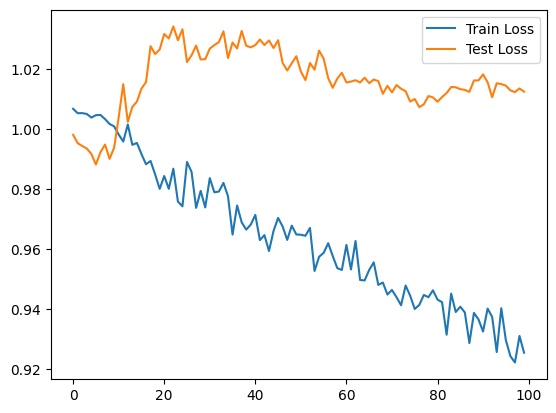

In [39]:
# Plot
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.legend();

In [40]:
# Make Prediction
# Note that we do not flatten() the prediction
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 21ms/step


In [41]:
# Shape
Ptrain.shape, Ptest.shape

((909, 10), (1, 10))

In [42]:
# Index our prediction
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [43]:
# Unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [44]:
# Save Multi-Step Forecast to DataFrame
df.loc[test_idx, 'Multi_OutPut'] = last_train + np.cumsum(Ptest)

In [45]:
# Plot all Forecasts
px.line(df, x=df.index, y=['Log_Close', '1_Step_pred_Test', 'Multi_Step', 'Multi_OutPut'])

In [46]:
# MAPE
test_log_Close = df.iloc[-Ntest:]['Log_Close']
mape_1 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, '1_Step_pred_Test'])
print('1Step MAPE: ', mape_1)
mape_2 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, 'Multi_Step'])
print('Multi-Step MAPE: ', mape_2)
mape_3 = mean_absolute_percentage_error(test_log_Close, df.loc[test_idx, 'Multi_OutPut'])
print('Multi-OutPut MAPE: ', mape_3)

1Step MAPE:  0.0006979963581228187
Multi-Step MAPE:  0.0011516512985628965
Multi-OutPut MAPE:  0.0011552988882276081


In [47]:
# R2 Score
test_log_Close = df.iloc[-Ntest:]['Log_Close']
R2_1 = r2_score(test_log_Close, df.loc[test_idx, '1_Step_pred_Test'])
print('1Step R2: ', R2_1)
R2_2 = r2_score(test_log_Close, df.loc[test_idx, 'Multi_Step'])
print('Multi-Step R2: ', R2_2)
R2_3 = r2_score(test_log_Close, df.loc[test_idx, 'Multi_OutPut'])
print('Multi-OutPut R2: ', R2_3)

1Step R2:  0.3216840121929637
Multi-Step R2:  -0.8067551501801018
Multi-OutPut R2:  -0.8035572226305543
